In [63]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib.patches import Patch

In [2]:
from multisoc.generate.multidimensional_network import multidimensional_network_fix_av_degree
from multisoc.generate.two_dimensional_population import consol_comp_pop_frac_tnsr
from multisoc.generate.two_dimensional_population import relative_correlation_inv
from multisoc.generate.utils import make_composite_index
from multisoc.theory.multidimensional_preferences import composite_H
from multisoc.metrics.fairness_metrics import *
from multisoc.theory.fairness_metrics import *

## Generate network

In [41]:
## Number of nodes and links
N = 500 ## Number of nodes
m = 20  ## Average number of connections per node

In [42]:
## Preferences (choose one)

##################################################################
## Arbitrary preferences
##################################################################

## List of 1d homophily matrices (2 for a two-dimensional system)
# h_mtrx_lst = [ 
    
#     np.array([[0.9,0.1],
#               [0.1,0.9]]),
    
#     np.array([[0.6,0.4],
#               [0.4,0.6]])
# ]

##################################################################
## Symmetric homophily
##################################################################

h = 0.8

h_mtrx_lst = [ 
    
    np.array([[h,1-h],
              [1-h,h]]),
    
    np.array([[h,1-h],
              [1-h,h]])
]

In [43]:
## Population distribution (choose one)

##################################################################
## Arbitrary population distribution
##################################################################

# ## The marginals of the population distribution defined by comp_pop_frac_tnsr
# ## Each row has to sum 1 (100% of the population)
# pop_fracs_lst = [
#     [0.2,0.8],
#     [0.4,0.6]
# ]

# ## Generate population distribution with certain level of corrrelation
# ## No correlation would correspond to the fraction of the largest minority
# consol = 0.4 ## Level of correlation - neutral correlation corresponds to the size of the largest minority out of the two minority groups in the two dimensions (0.4 in this example)
# comp_pop_frac_tnsr = consol_comp_pop_frac_tnsr(pop_fracs_lst,consol)

##################################################################
## Interesting distribution I
##################################################################

f1m = 0.32
f2m = 0.48

assert f1m < f2m

pop_fracs_lst = [
    [f1m,1-f1m],
    [f2m,1-f2m]
]

correlation = -0.9 ## Try: -0.9,-0.3,0,0.3,0.9
consol = relative_correlation_inv(f2m,correlation)
comp_pop_frac_tnsr = consol_comp_pop_frac_tnsr(pop_fracs_lst,consol)

##################################################################
## Interesting distribution II
##################################################################

# f1m = 0.40
# f2m = 0.41

# assert f1m < f2m

# pop_fracs_lst = [
#     [f1m,1-f1m],
#     [f2m,1-f2m]
# ]

# consol = 0.1
# comp_pop_frac_tnsr = consol_comp_pop_frac_tnsr(pop_fracs_lst,consol)

In [44]:
kind = "all" ## Aggregation function: {all->and, one->mean, any->or}
p_d = [0.5, 0.5] ## Weight of each dimension for "mean" aggregation function

G = multidimensional_network_fix_av_degree(
                h_mtrx_lst,
                comp_pop_frac_tnsr,
                kind,
                directed=True, ## Directed or undirected network
                pop_fracs_lst = pop_fracs_lst,
                N=N,
                m=m,
                v = 0,
                p_d = p_d
                )

In [45]:
## Remove isolated nodes and compute positions of nodes
G.remove_nodes_from(list(nx.isolates(G)))
pos = nx.kamada_kawai_layout(G,scale=3)

In [46]:
# Setup visualization
# color_dict = {
#     (0,0):"#84e8af",
#     (0,1):"#c0cdf9",
#     (1,0):"#f0cd6f",
#     (1,1):"#ffabb0"
#     }

color_dict = {
    (0,0):"#8A2846",
    (0,1):"#03045E",
    (1,0):"#FFC2D4",
    (1,1):"#CAF0F8"
    }
groups_lst = [(0,0),(0,1),(1,0),(1,1)]
group_labels = [["B","W"],["♀","♂"]]
colors_race = ["#595959","#d9d9d9"]
colors_gender = ["#c63963","#3A6CC6"]

In [47]:
# Setup visualization

nodelist = G.nodes()
node_colors = [color_dict[G.nodes[i]["attr"]] for i in nodelist]
n = len(G.nodes())
node_size = 40000*(1/(n+200))

degs = np.array([G.degree()[i] for i in nodelist])
node_size_list =  node_size*0.1+(node_size*4-node_size*0.1)*(degs-min(degs))/(max(degs)-min(degs))

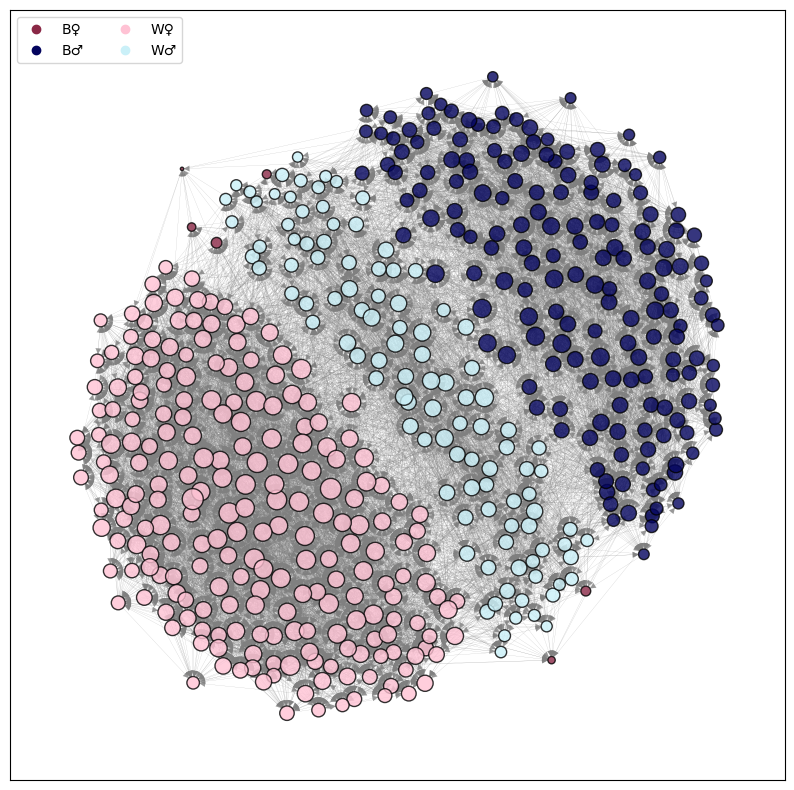

In [48]:
## Draw network (takes a while)
plt.figure(figsize=(10,10))

nx.draw_networkx(G,
                     with_labels = False,
                     pos=pos,
                     nodelist=nodelist,
                     node_color=node_colors,
                     node_size=node_size_list,
                     # node_shape=shape_dict[key],
                     width=0.1,
                     alpha = .8,
                     arrowstyle = '-|>',
                     linewidths = 1,
                     edgecolors = 'black',
                     edge_color = 'grey', ## v2
                     # ax=ax
                )

plt.plot([],[],"o",label="B♀",color=color_dict[(0,0)])
plt.plot([],[],"o",label="B♂",color=color_dict[(0,1)])
plt.plot([],[],"o",label="W♀",color=color_dict[(1,0)])
plt.plot([],[],"o",label="W♂",color=color_dict[(1,1)])

plt.legend(loc="upper left",ncol=2)
plt.show()

## Measure inequalities in synthetic network

In [49]:
g_vec = [2,2]
full_ineq_dict = get_inequality_info_from_graph(G,g_vec,attribute_key="attr",ineq_fun=common_language_delta)
full_ineq_dict

{'dim0_g0': -0.3650989010989011,
 'dim0_g1': 0.365098901098901,
 'dim0_(0, 0)': 0.0,
 'dim0_(0, 1)': -0.3650989010989011,
 'dim0_(1, 0)': 0.365098901098901,
 'dim0_(1, 1)': 0.0,
 'dim1_g0': 0.5115474747474746,
 'dim1_g1': -0.5115474747474749,
 'dim1_(0, 0)': 0.0,
 'dim1_(0, 1)': 0.5115474747474746,
 'dim1_(1, 0)': -0.5115474747474749,
 'dim1_(1, 1)': 0.0,
 'multi(0, 0)': -0.8977732793522267,
 'multi((0, 0), (0, 0))': 0.0,
 'multi((0, 0), (0, 1))': -0.8599605522682445,
 'multi((0, 0), (1, 0))': -0.9756468797564688,
 'multi((0, 0), (1, 1))': -0.7971698113207547,
 'multi(0, 1)': -0.323638248806736,
 'multi((0, 1), (0, 0))': 0.8599605522682434,
 'multi((0, 1), (0, 1))': 0.0,
 'multi((0, 1), (1, 0))': -0.5455945529707384,
 'multi((0, 1), (1, 1))': 0.06793569275427025,
 'multi(1, 0)': 0.5575813711630022,
 'multi((1, 0), (0, 0))': 0.9756468797564679,
 'multi((1, 0), (0, 1))': 0.5455945529707387,
 'multi((1, 0), (1, 0))': 0.0,
 'multi((1, 0), (1, 1))': 0.5530283449642457,
 'multi(1, 1)': -0.32

## Compute analytical predicted inequalities

### Using multidimensioanl model

In [50]:
H = composite_H(h_mtrx_lst,"all")
F = comp_pop_frac_tnsr
predicted_onedime_ineq = analytical_1vRest_onedimensional_deltas(H,F,N)
predicted_multi_ineq = analytical_1vRest_multidimensional_deltas(H,F,N)
predicted_onedime_ineq, predicted_multi_ineq

({0: {0: -0.7765073610406887, 1: 0.7765073610406887},
  1: {0: 0.9271035887476409, 1: -0.9271035887476409}},
 {(0, 0): -0.999969166536156,
  (0, 1): -0.7262481757545522,
  (1, 0): 0.9910713024363201,
  (1, 1): -0.45899293258596896})

### One dimension at a time

In [51]:
onedim_deltas_hypothetical_1d = {}
for d in range(F.ndim):
    onedim_deltas_hypothetical_1d[d] = {}
    H_theor_1D = h_mtrx_lst[d]
    F_1D = np.array(pop_fracs_lst[d])
    onedim_deltas_hypothetical_i = analytical_1vRest_onedimensional_deltas(H_theor_1D,F_1D,N)
    for vi in range(F.shape[d]):
        onedim_deltas_hypothetical_1d[d][vi] = onedim_deltas_hypothetical_i[0][vi]

In [52]:
onedim_deltas_hypothetical_1d

{0: {0: -0.9999988108029625, 1: 0.9999988108029625},
 1: {0: -0.4084289104694413, 1: 0.4084289104694413}}

## Plot analytical and simulated inequalities

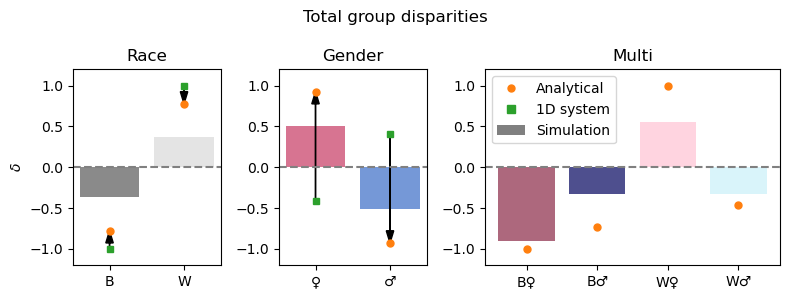

In [66]:
fig, axs = plt.subplots(1,3,figsize=(8,3),width_ratios=[2,2,4])
plt.suptitle("Total group disparities")

plt.sca(axs[0])
plt.title("Race")
plt.bar(["B","W"],[full_ineq_dict["dim0_g0"],full_ineq_dict["dim0_g1"]],alpha=0.7,color=colors_race)
plt.plot([0,1],[predicted_onedime_ineq[0][0],predicted_onedime_ineq[0][1]],"o",color="C1",ms=5)
plt.plot([0,1],[onedim_deltas_hypothetical_1d[0][0],onedim_deltas_hypothetical_1d[0][1]],"s",color="C2",ms=5)
plt.axhline(0,color="grey",ls="--")

plt.arrow(0, onedim_deltas_hypothetical_1d[0][0], 0,predicted_onedime_ineq[0][0]-onedim_deltas_hypothetical_1d[0][0], shape='full', lw=1, length_includes_head=True, head_width=.1,color="k")
plt.arrow(1, onedim_deltas_hypothetical_1d[0][1], 0,predicted_onedime_ineq[0][1]-onedim_deltas_hypothetical_1d[0][1], shape='full', lw=1, length_includes_head=True, head_width=.1,color="k")


plt.ylim(-1.2,1.2)
plt.ylabel(r"$\delta$")

plt.sca(axs[1])
plt.title("Gender")
plt.bar(["♀","♂"],[full_ineq_dict["dim1_g0"],full_ineq_dict["dim1_g1"]],alpha=0.7,color=colors_gender)
plt.plot([0,1],[predicted_onedime_ineq[1][0],predicted_onedime_ineq[1][1]],"o",color="C1",ms=5)
plt.plot([0,1],[onedim_deltas_hypothetical_1d[1][0],onedim_deltas_hypothetical_1d[1][1]],"s",color="C2",ms=5)
plt.axhline(0,color="grey",ls="--")

plt.arrow(0, onedim_deltas_hypothetical_1d[1][0], 0,predicted_onedime_ineq[1][0]-onedim_deltas_hypothetical_1d[1][0], shape='full', lw=1, length_includes_head=True, head_width=.1,color="k")
plt.arrow(1, onedim_deltas_hypothetical_1d[1][1], 0,predicted_onedime_ineq[1][1]-onedim_deltas_hypothetical_1d[1][1], shape='full', lw=1, length_includes_head=True, head_width=.1,color="k")

plt.ylim(-1.2,1.2)

plt.sca(axs[2])
plt.title("Multi")
plt.bar(["B♀","B♂","W♀","W♂"],
        [full_ineq_dict["multi(0, 0)"],full_ineq_dict["multi(0, 1)"],full_ineq_dict["multi(1, 0)"],full_ineq_dict["multi(1, 1)"]],
        alpha=0.7,color=[color_dict[i] for i in groups_lst])
plt.plot([0,1,2,3],[predicted_multi_ineq[(0, 0)],predicted_multi_ineq[(0, 1)],predicted_multi_ineq[(1, 0)],predicted_multi_ineq[(1, 1)]],"o",color="C1",ms=5,label="Analytical")
plt.axhline(0,color="grey",ls="--")
plt.plot([],[],"s",color="C2",label="1D system")
plt.bar(0,0,color=["grey"],label="Simulation")
plt.ylim(-1.2,1.2)

plt.legend()
plt.tight_layout()
plt.show()